In [86]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../..')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
import numpy as np
from hyperbolicity.tree_fitting_methods.neighbor_joining import NJ
from hyperbolicity.tree_fitting_methods.treerep import TreeRep
from hyperbolicity.tree_fitting_methods.hccfit import HccLinkage
from hyperbolicity.tree_fitting_methods.gromov import gromov_tree, buneman_extraction
from hyperbolicity.delta import compute_hyperbolicity
from hyperbolicity.tree_fitting_methods.layering_tree import layering_approx_tree
from hyperbolicity.tree_fitting_methods.hdtree import hdtree
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
import torch
import ot

plt.rcParams['text.usetex'] = True


import seaborn as sns
sns.set_theme(style="white")

In [88]:
import torch
from hyperbolicity.tree_fitting_methods.gromov import gromov_tree
from hyperbolicity.utils import construct_weighted_matrix
from hyperbolicity.tree_fitting_methods.hyperbolicity_learning_GW import train_distance_matrix_GW

def hdtree_GW(distances: torch.Tensor,
           root: int,
           lr: float,
           num_leaves: int,
           scale_delta: float,
           distance_reg: float,
           num_epochs: int,
           gpu: bool,
           verbose: bool):

       weights, _,_, _,_ = train_distance_matrix_GW(distances,num_leaves, scale_delta, distance_reg, num_epochs, lr, verbose, gpu)
       edges = torch.triu_indices(num_leaves, num_leaves, offset=1)
       distance_optimized = construct_weighted_matrix(weights, num_leaves, edges)
       # compute final coupling matrix
       G = ot.gromov_wasserstein(distances,distance_optimized,loss_fun='square_loss', max_iter=1000, log=False, verbose=False)

       distance_optimized_cpu = distance_optimized.cpu().numpy()
       T_opt = gromov_tree(distance_optimized_cpu, root)

       return T_opt, G

In [89]:
from matplotlib.colors import Normalize

def draw_graph(n, distances, tree, ax, title='Tree', fixed_pos=None, fixed_nodes=None,
               node_size=500, edge_color='gray',root=0,show_root=True,
               orig_color = '#FE6100',
               int_color  = '#648FFF',
               root_color = '#DC267F',
               cmap=sns.color_palette("Blues", as_cmap=True),
               with_labels=True,
               scale_width=1,
               fs=24,
               vmin=0, vmax=2):

    orig_nodes_nj = [v for v in tree.nodes() if v < n]
    int_nodes_nj  = [v for v in tree.nodes() if v >= n]

    # Set edge weights from the distance matrix M
    edge_values = {}
    for (u, v) in tree.edges():
        tree[u][v]['weight_layout'] = 1
        edge_values[(u,v)]= distances[u, v]

    norm = Normalize(vmin=vmin, vmax=vmax)
    edge_colors = [cmap(norm(edge_values[(u,v)])) for (u,v) in tree.edges()]
    # Get positions for the nodes
    pos = nx.spring_layout(tree, pos=fixed_pos, fixed=fixed_nodes, weight='weight_layout',  iterations=1000)

    nx.draw_networkx_edges(tree, pos, ax=ax, edge_color=edge_colors, width=scale_width)
    #nx.draw_networkx_edges(tree, pos, ax=ax)
    nx.draw_networkx_nodes(tree, pos,
                        nodelist=int_nodes_nj,
                        node_color=int_color,  node_size=node_size/2,
                        ax=ax)
    nx.draw_networkx_nodes(tree, pos,
                        nodelist=orig_nodes_nj,
                        node_color=orig_color, node_size=node_size,
                        ax=ax)

    if show_root:
        nx.draw_networkx_nodes(tree, pos,
                        nodelist=[root] if root in tree else [],
                        node_color=root_color,
                        node_size=node_size, ax=ax)

    if with_labels:
        nx.draw_networkx_labels(tree, pos,
                                labels={v: str(v) for v in tree.nodes()},
                                font_size=20, font_color='black',
                                ax=ax)

    ax.set_title(title, pad=10,fontsize=fs)
    ax.axis('off')


def plot_distances(distances, ax, vmin=0, vmax=10,
                   cmap=sns.diverging_palette(230, 20, as_cmap=True)):
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(distances, dtype=bool),k=1)

    # Draw the heatmap with the mask and correct aspect ratio
    #sns.heatmap(distances, mask=mask, cmap=cmap, vmin=vmin, vmax=vmax, center=0,
    #            square=True, linewidths=.5, cbar_kws={"shrink": .6},ax=ax)
    sns.heatmap(distances, mask=mask, cmap=cmap, vmin=vmin, vmax=vmax,
                square=True, linewidths=.7, cbar=False,ax=ax)

# Data part

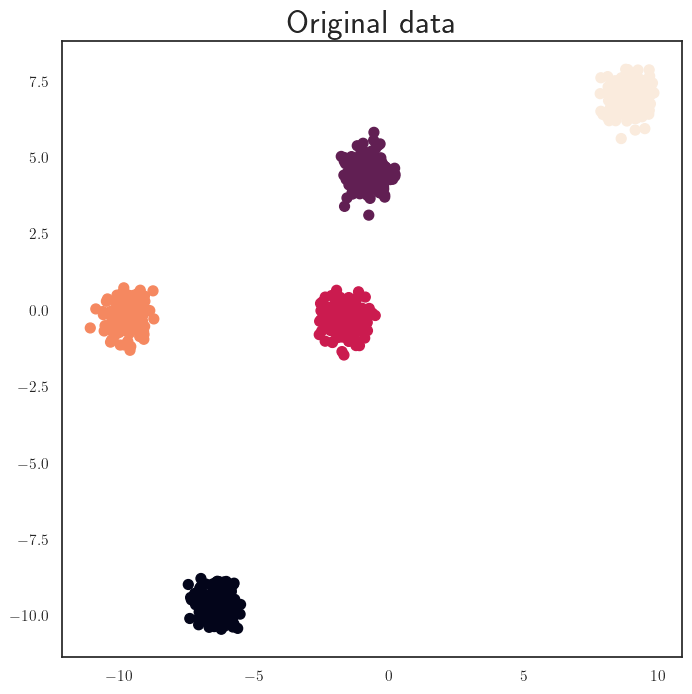

In [95]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_moons
import ot


n_components = 5
X, truth = make_blobs(n_samples=1000, centers=n_components,
                      cluster_std = .4,
                      random_state=11)

#X,truth = make_moons(n_samples=1000, noise=.05, random_state=42)

fig = plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], s=50, c = truth)
plt.title(f"Original data",fontsize=24)

distances=torch.from_numpy(ot.dist(X, X)).float()

# generate graph and compute stuff

In [97]:
root =2
num_leaves = 10

opt_tree, G = hdtree_GW(torch.tensor(distances),root, 1e-1 ,num_leaves, 1000, .01, 2000, False, True)
opt_tree_full = buneman_extraction(opt_tree, root)
distance_hdtree = nx.floyd_warshall_numpy(opt_tree_full)


/var/folders/fj/02wx0ctd7vv0g1x6f6fb2j9m0000gn/T/ipykernel_98041/3436259170.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  opt_tree, G = hdtree_GW(torch.tensor(distances),root, 1e-1 ,num_leaves, 1000, .01, 2000, False, True)
loss = 86.95082, delta = 0.16604, error = 8678.47852: 100%|██████████| 2000/2000 [02:50<00:00, 11.70it/s]  


display

In [98]:
# reconstruct positions of leaves from coupling
pos_torch = G.shape[1] * G.T @ X
pos = {}
for i in range(pos_torch.shape[0]):
    pos[i] = pos_torch[i].numpy()


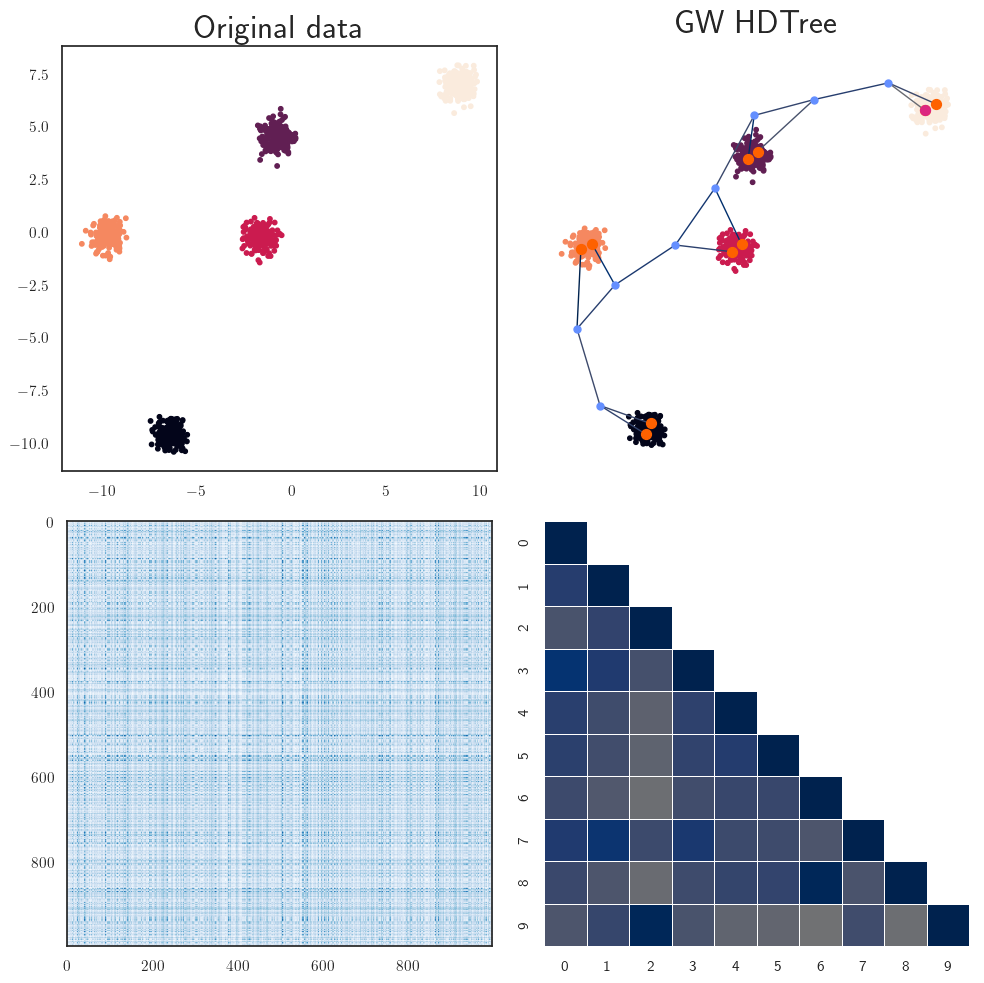

In [99]:
node_size = 50
size_fig = 5
cmap_dist = sns.color_palette(palette='cividis', as_cmap=True)
#sns.diverging_palette(220,30, l=65, center="dark", as_cmap=True)#sns.color_palette("icefire", as_cmap=True)
vmin = 0
vmax = distances.max().item()
fs=24

a=2
b=2
# let's plot the trees
fig, axes = plt.subplots(a, b, figsize=(a * size_fig, b * size_fig))


ax = axes[0, 0]
ax.scatter(X[:, 0], X[:, 1], s=10, c = truth)
ax.set_title(f"Original data",fontsize=fs)

ax = axes[1, 0]
ax.imshow(distances,cmap='Blues')

ax = axes[0, 1]
ax.scatter(X[:, 0], X[:, 1], s=10, c = truth)
l = np.argsort(opt_tree_full.nodes)
draw_graph(num_leaves, distance_hdtree[l], opt_tree_full, ax, title='GW HDTree', fixed_pos=pos, fixed_nodes=range(num_leaves),
           cmap=cmap_dist, node_size=node_size, root=root, vmax=vmax, fs=fs, with_labels=False)

ax = axes[1, 1]
plot_distances(distance_hdtree[l][:num_leaves, l[:num_leaves]], ax, vmin=vmin, vmax=vmax, cmap=cmap_dist)

plt.tight_layout()
plt.show()